In [2]:
import os
import sys

sys.path.append(os.path.abspath("../src"))

import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns

from data_processing import (
    extract_date_features,
    build_aggregate_features,
    clean_data,
    build_preprocessor
)


## 🏗️ Step 1: Merge Proxy Target

In [3]:
# Load processed cluster labels
proxy_target = pd.read_csv('../data/processed/proxy_target.csv')

# Load transaction data
data = pd.read_csv('../data/raw/data.csv')

# Merge
data = pd.merge(data, proxy_target, on='CustomerId', how='left')

# Convert datetime
data['TransactionStartTime'] = pd.to_datetime(data['TransactionStartTime'])

print(data.shape)
data.head()


(95662, 17)


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,Cluster
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0,1
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0,1
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0,1
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0,1


## 🔧 Step 2: Feature Engineering (Reuse from Task 3)

In [ ]:
# Apply feature engineering
data = extract_date_features(data)
data = build_aggregate_features(data)
data_clean = clean_data(data)


## 🎯 Step 3: Define Features and Target

In [5]:
X = data_clean.drop(columns=['FraudResult', 'Cluster'])
y = data_clean['Cluster']  # Proxy target from Task 4

print(f"Features: {X.shape}, Target: {y.shape}")


Features: (95662, 17), Target: (95662,)


## ✂️ Step 4: Train-Test Split

In [6]:
# from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (76529, 17), Test: (19133, 17)


## 🔥 Step 5: Build Full Pipeline with Model

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Build preprocessor
preprocessor = build_preprocessor()

# Logistic Regression pipeline
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=500, random_state=42))
])

# Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


## 🔥 Step 6. Setup MLflow Experiment

In [8]:
mlflow.set_experiment("customer_segmentation_experiment")

2025/06/30 17:40:01 INFO mlflow.tracking.fluent: Experiment with name 'customer_segmentation_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/ME/KAIM/week5/credit-risk-scoring-model/notebooks/mlruns/575654473440926346', creation_time=1751294401510, experiment_id='575654473440926346', last_update_time=1751294401510, lifecycle_stage='active', name='customer_segmentation_experiment', tags={}>

## 🔍 Step 7. Hyperparameter Tuning and Training with MLflow

In [9]:
models = {
    "LogisticRegression": logistic_pipeline,
    "RandomForest": rf_pipeline
}

params = {
    "LogisticRegression": {
        'classifier__C': [0.01, 0.1, 1.0, 10.0]
    },
    "RandomForest": {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    }
}

best_models = {}

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        print(f"Training {name}")

        grid = GridSearchCV(model, params[name], cv=3, scoring='f1_weighted')
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        best_models[name] = best_model

        y_pred = best_model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted')
        rec = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        roc = roc_auc_score(y_test, pd.get_dummies(y_test), multi_class='ovo')

        print(f"Best Params: {grid.best_params_}")
        print(f"Accuracy: {acc}, F1: {f1}")

        # Log params and metrics
        mlflow.log_params(grid.best_params_)
        mlflow.log_metrics({
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "roc_auc": roc
        })

        # Log model
        mlflow.sklearn.log_model(best_model, name)

        print(f"Finished logging {name}")


Training LogisticRegression


2025/06/30 17:40:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Params: {'classifier__C': 10.0}
Accuracy: 0.9262008048920712, F1: 0.9210145826349659


2025/06/30 17:43:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Finished logging LogisticRegression
Training RandomForest


2025/06/30 17:50:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Params: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
Accuracy: 0.9903831077196467, F1: 0.9903755505201322


2025/06/30 17:50:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Finished logging RandomForest


## 📊 Step 8: Evaluate the Model

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2202
           1       0.99      0.99      0.99     16113
           2       1.00      1.00      1.00       818

    accuracy                           0.99     19133
   macro avg       0.98      0.98      0.98     19133
weighted avg       0.99      0.99      0.99     19133



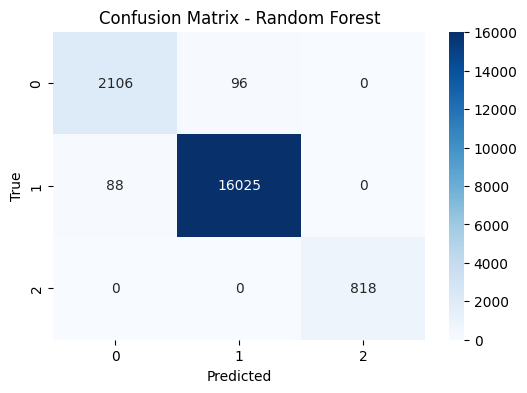

In [10]:
final_model = best_models['RandomForest']
y_pred = final_model.predict(X_test)

print(classification_report(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 💾 Step 9: Save the best Model

In [11]:
import joblib

joblib.dump(final_model, '../models/rfm_cluster_model.pkl')

print("Model saved to '../models/rfm_cluster_model.pkl'")


Model saved to '../models/rfm_cluster_model.pkl'
